# Grandes cidades brasileiras são progressistas?

O objetivo do estudo é entender se existe algum movimento similar ao EUA em que grandes cidades tendem a ser mais *progressistas* e cidades menores mais *conservadoras*.

Para isso é analisado o total de prefeitos eleitos por partido por densidade populacional.

No cenário brasileiro é extremamente complicado definir o mapa ideológio dos partidos, por exemplo, o diretório nacional de um partido pode ter um viés mais centro/direita e o diretório estadual mais centro/esquerda. Como o autor desconhece uma forma objetiva de classificar a ideologia dos partidos por região, é utilizado o GPS ideológico da Folha: http://temas.folha.uol.com.br/gps-ideologico/

**Mapa ideológico dos partidos**

- <ins>Esquerda</ins>: PCB / PT, UP, PSOL, PSTU / PC DO B, PCO / PDT, REDE, PSB, PV
- <ins>Centro</ins>: SD, PROS, PTB / PRB, MDB, PP / PSDB, PMN, PMB / CDD, PSD
- <ins>Direita</ins>: DEM, PL, DC, AVT, PSC, PODE / PATRI / NOVO, PRTB, PSL / PTC

Uma alternativa seria utilizar o basômetro do Estadão: https://arte.estadao.com.br/politica/basometro/

O autor também entende que é uma visão simplista agrupar os partidos em um único grupo ideológico, existem diversas esquerdas (progressista, trabalhista, socialista...), centros (centro democrático e centrão) e direitas (liberal, conversadora, reacionária...), porém isso pode ser refinado no futuro.

**Cidades grandes e pequenas**

A classificação de grandes e pequenas cidades é definida utilizando os seguintes critérios:
- <ins>Grandes cidades</ins>: Municípios com densidade populacional entre 200 e 20k pop/km2 (~400 cidades)
- <ins>Pequenas cidades</ins>: Municípios com densidade populacional entre 0 e 200 pop/km2 (~5168 cidades)

**Referências**
- https://engaging-data.com/election-population-density/
- https://www.pewresearch.org/politics/interactives/political-polarization-1994-2017/
- https://news.gallup.com/poll/275792/remained-center-right-ideologically-2019.aspx
- https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html

**Notas**

- PRN virou PTC em 2000
- PPB virou PP em abril de 2003
- PFL virou DEM em março de 2007
- PTN virou PODE em maio de 2017
- PT DO B virou AVT em setembro de 2017
- PEN virou PATRI em abril de 2018
- PMDB virou MDB em maio de 2018
- PSDC virou DC em maio de 2018
- PPS virou CDD em março de 2019
- PR virou PL em maio de 2019
- PRB virou PR em agosto de 2019
- PST, PHS, PRP, PPL, PAN e PRONA foram extintos

In [1]:
import pandas as pd
import six
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
import geopandas as gpd

from pandas.plotting import table 
from IPython.display import HTML
from unidecode import unidecode

%matplotlib inline

# Ler repositório de votação do TSE (1996-2018)

Dados compilados pelo Brasil.io: https://brasil.io/dataset/eleicoes-brasil/votacoes/

In [2]:
cols = ['ano_eleicao', 'descricao_totalizacao_turno', 
        'codigo_municipio', 'nome_municipio', 'sigla_uf', 'nome_partido', 'numero_partido', 
        'sigla_partido', 'descricao_cargo', 'nome', 'numero_urna', 'numero_zona', 'total_votos']

df_chunk = pd.read_csv('input/2019-04-08/votacao-zona.csv', sep=',', usecols=cols, encoding='latin1', chunksize=1000000)

In [3]:
chunk_list = []

for chunk in df_chunk:  
    chunk_filter = chunk[chunk.descricao_cargo == 'PREFEITO']
    chunk_filter = chunk_filter[chunk_filter.descricao_totalizacao_turno.isin(['ELEITO', 'ELEITO POR QP', 'ELEITO POR MEDIA'])]
    chunk_filter.drop(['descricao_totalizacao_turno', 'descricao_cargo'], axis=1, inplace=True)
    chunk_list.append(chunk_filter)    
df_concat = pd.concat(chunk_list)

C:\Users\guilh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dados parciais 2020

In [402]:
cols = ['codtse','ncand','nome','partido','votabs','situacao','uf']
df_2020 = pd.read_csv('input/prefeitos2020.csv', sep=';', usecols=cols)

In [403]:
df_2020 = df_2020[df_2020.situacao == 'Eleito']
df_2020.drop('situacao', axis=1, inplace=True)
df_2020.columns = ['codigo_municipio', 'numero_urna', 'nome', 'sigla_partido', 'total_votos', 'sigla_uf']

Criar colunas para satisfazer dataset principal

In [404]:
df_2020['ano_eleicao'] = 2020
df_2020['numero_partido'] = df_2020['numero_urna']
df_2020['numero_zona'] = 0

In [405]:
df_temp = pd.read_excel('input/tse_partidos.xlsx')
dict_partidos = pd.Series(df_temp.NOME.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['nome_partido'] = df_2020.numero_partido.map(dict_partidos)

In [406]:
dict_sigla_partidos = pd.Series(df_temp.SIGLA.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['sigla_partido'] = df_2020.numero_partido.map(dict_sigla_partidos)

In [407]:
df_temp = df_concat[['codigo_municipio', 'nome_municipio']].drop_duplicates('codigo_municipio', keep='first').sort_values('codigo_municipio')
dict_municipios = pd.Series(df_temp.nome_municipio.values, index = df_temp.codigo_municipio.values).to_dict()
df_2020['nome_municipio'] = df_2020.codigo_municipio.map(dict_municipios)

In [408]:
df = df_concat.append(df_2020, sort=False)
df = df.groupby(['ano_eleicao','codigo_municipio','nome_municipio','sigla_uf','nome_partido',
                   'numero_partido','sigla_partido','nome','numero_urna'])['total_votos'].sum().reset_index()

# Filtrar por ano da eleição

In [409]:
ano_da_eleicao = df.ano_eleicao.unique().tolist()[1:]

Renomear partidos antigos

In [410]:
df.sigla_partido.replace('PRN','PTC', inplace=True)
df.sigla_partido.replace('PPB','PP', inplace=True)
df.sigla_partido.replace('PFL','DEM', inplace=True)
df.sigla_partido.replace('PTN','PODE', inplace=True)
df.sigla_partido.replace('PT DO B','AVT', inplace=True)
df.sigla_partido.replace('PEN','PATRI', inplace=True)
df.sigla_partido.replace('PMDB','MDB', inplace=True)
df.sigla_partido.replace('PSDC','DC', inplace=True)
df.sigla_partido.replace('PPS','CDD', inplace=True)
df.sigla_partido.replace('PR','PL', inplace=True)

# Mapa ideológico dos partidos

In [411]:
mapa_ideologico = {'PCB':'Esquerda',
                    'PT':'Esquerda',
                    'UP':'Esquerda',
                    'PSOL':'Esquerda',
                    'PSTU':'Esquerda',
                    'PC DO B':'Esquerda',
                    'PCO':'Esquerda',
                    'PDT':'Esquerda',
                    'REDE':'Esquerda',
                    'PSB':'Esquerda',
                    'PV':'Esquerda',
                    'SD':'Centro',
                    'PROS':'Centro',
                    'PTB':'Centro',
                    'PRB':'Centro',
                    'PP':'Centro',
                    'PMN':'Centro',
                    'PMB':'Centro',
                    'MDB':'Centro',
                    'PSDB':'Centro',
                    'CDD':'Centro',
                    'PSD':'Centro',
                    'DEM':'Direita',
                    'PL':'Direita',
                    'DC':'Direita',
                    'AVT':'Direita',
                    'PSC':'Direita',
                    'PODE':'Direita',
                    'PATRI':'Direita',
                    'NOVO':'Direita',
                    'PRTB':'Direita',
                    'PSL':'Direita',
                    'PTC':'Direita',
                    'PST':'Esquerda',
                    'PHS':'Direita',
                    'PRP':'Direita',
                    'PPL':'Esquerda',
                    'PAN':'Centro',
                    'PRONA':'Direita'}

In [412]:
df['ideologia'] = df.sigla_partido.map(mapa_ideologico)

# Lista de população, tamanho e densidade por município

In [413]:
sigla_estado = {'AC':'Acre',
                'AL':'Alagoas',
                'AP':'Amapa',
                'AM':'Amazonas',
                'BA':'Bahia',
                'CE':'Ceara',
                'DF':'Distrito Federal',
                'ES':'Espirito Santos',
                'GO':'Goias',
                'MA':'Maranhao',
                'MT':'Mato Grosso',
                'MS':'Mato Grosso do Sul',
                'MG':'Minas Gerais',
                'PA':'Para',
                'PB':'Paraiba',
                'PR':'Parana',
                'PE':'Pernambuco',
                'PI':'Piaui',
                'RJ':'Rio de Janeiro',
                'RN':'Rio Grande do Norte',
                'RS':'Rio Grande do Sul',
                'RO':'Rondonia',
                'RR':'Roraima',
                'SC':'Santa Catarina',
                'SP':'Sao Paulo',
                'SE':'Sergipe',
                'TO':'Tocantins'}

In [414]:
regioes = {'Norte':['AC','AP','AM','PA','RO','RR','TO'],
           'Nordente':['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
           'Centro-Oeste':['GO','MT','MS'],
           'Sudeste':['ES','MG','RJ','SP'],
           'Sul':['PR','SC','RN']}

In [415]:
capitais = {'AC':'Rio Branco',
            'AL':'Maceio',
            'AP':'Macapa',
            'AM':'Manaus',
            'BA':'Salvador',
            'CE':'Fortaleza',
            'DF':'Brasilia',
            'ES':'Vitoria',
            'GO':'Goiania',
            'MA':'São Luis',
            'MT':'Cuiaba',
            'MS':'Campo Grande',
            'MG':'Belo Horizonte',
            'PA':'Belem',
            'PB':'Joao Pessoa',
            'PR':'Curitiba',
            'PE':'Recife',
            'PI':'Teresina',
            'RJ':'Rio de Janeiro',
            'RN':'Natal',
            'RS':'Porto Alegre',
            'RO':'Porto Velho',
            'RR':'Boa Vista',
            'SC':'Florianopolis',
            'SP':'Sao Paulo',
            'SE':'Aracaju',
            'TO':'Palmas'}

Obter lista da população, tamanho e densidade por município

In [416]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o_(2020)'
municipio_pop = pd.read_html(url, thousands=' ')[0]

# eliminar espaço para converter para int
municipio_pop['População'] = municipio_pop['População'].str.replace('\D', '').astype(int)

# converter estado e municipio para sem acentos e maiusculo
municipio_pop['Unidade federativa'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: unidecode(x))
municipio_pop['Município'] = municipio_pop['Município'].str.upper().apply(lambda x: unidecode(x))

# abreviar UF
municipio_pop['sigla_uf'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: [k for k, v in sigla_estado.items() if (unidecode(v.upper()) == x)])
municipio_pop = municipio_pop.explode('sigla_uf')

municipio_pop.drop('Posição', axis=1, inplace=True)
municipio_pop.set_index('Código IBGE', inplace=True)

In [417]:
url = 'https://pt.m.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente'
municipio_km = pd.read_html(url, thousands=' ')[0]

municipio_km['Área (km²)'] = municipio_km['Área (km²)'].str.replace(',','.').str.replace(u'\xa0', u'').astype(float)
municipio_km.drop(['Posição','Município', 'Unidade federativa'], axis=1, inplace=True)
municipio_km.rename(columns={'Código do IBGE':'Código IBGE'}, inplace=True)
municipio_km.set_index('Código IBGE', inplace=True)

In [418]:
density_label = ['0-5','5-10','10-20','20-50','50-100','100-200','200-20k']

def grupo_densidade(den):
    if den >= 0 and den < 5:
        return 0
    elif den >= 5 and den < 10:
        return 1
    elif den >= 10 and den < 20:
        return 2
    elif den >= 20 and den < 50:
        return 3
    elif den >= 50 and den < 100:
        return 4
    elif den >= 100 and den < 200:
        return 5
    elif den >= 200 and den < 20000:
        return 6
    else:
        return 'other'

In [419]:
municipios = pd.merge(municipio_pop, municipio_km, on='Código IBGE')
municipios['densidade'] = municipios['População'] / municipios['Área (km²)']

In [420]:
municipios['grupo_densidade'] = municipios.apply(lambda x : grupo_densidade(x.densidade), axis=1)

In [421]:
# Obter tabela de correspondencia entre codigo de municipio do IBGE e TSE
link = 'https://raw.githubusercontent.com/estadao/como-votou-sua-vizinhanca/master/data/votos/correspondencia-tse-ibge.csv'
df_equivalencia = pd.read_csv(link)
df_equivalencia.set_index('COD_TSE', drop=False, inplace=True)
df_equivalencia.drop(['chave','NOME','UF'], axis=1, inplace=True)

In [422]:
df.set_index('codigo_municipio', drop=False, inplace=True)
df = df.join(df_equivalencia)

In [423]:
df.set_index('GEOCOD_IBGE', drop=False, inplace=True)
df = df.join(municipios[['População','densidade','grupo_densidade']])

Latitude e Longitude

In [424]:
# Obter tabela latitude e longitude para municipios
link = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv'
df_lat_long = pd.read_csv(link)
df_lat_long.set_index('codigo_ibge', inplace=True)
df_lat_long.drop(['nome','capital','codigo_uf'], axis=1, inplace=True)

In [425]:
df = df.join(df_lat_long)

# Funções auxiliares

In [426]:
def group_by_density(df, ideology=False):
    res = pd.DataFrame()
    for i, val in enumerate(ano_da_eleicao):
        # Filtrar pelo ano e remover municipios duplicados
        df_by_year = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')

        # Agrupar municipios eleitos por partido
        df_temp = df_by_year.groupby('sigla_partido').count().sort_values('codigo_municipio', ascending=False).iloc[:,0]
        df_temp = df_temp.reset_index(name=val).set_index('sigla_partido')
       
        res = res.join(df_temp, how='outer') 
        
    res.fillna(0,inplace=True)    
    return res

In [427]:
def group_by_year(df):
    res = pd.DataFrame()
    for i, val in enumerate(ano_da_eleicao):
        # Filtrar pelo ano e remover municipios duplicados
        df_by_year = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')

        # Agrupar municipios eleitos por partido
        df_temp = df_by_year.groupby('sigla_partido').count().sort_values('codigo_municipio', ascending=False).iloc[:,0]
        df_temp = df_temp.reset_index(name=val).set_index('sigla_partido')
       
        res = res.join(df_temp, how='outer') 
        
    res.fillna(0,inplace=True)    
    return res

In [428]:
def draw_barchart(year, df, ax, title, textstr):
    res_by_year = df[[year]].dropna().sort_values(by=year, ascending=False).astype(int).head(10)
    ax.clear()
    b = sns.barplot(y=res_by_year.index, x=res_by_year.iloc[:,0], data=res_by_year, palette='plasma', ax=ax)

    plt.title(title, fontsize=25, fontweight='bold')
    plt.xlabel('Municípios', fontsize=15, fontweight='bold')
    plt.ylabel('Partidos', fontsize=15, fontweight='bold')

    b.set_yticks([])
    plt.xticks(fontsize=15)

    dx = res_by_year.iloc[:,0].max() / 100
    pos = range(res_by_year.shape[0])
    for tick in pos:
        ax.text(res_by_year.iloc[tick,0]-dx, pos[tick], res_by_year.index[tick], ha='right', va='center',
                fontsize=25, fontweight='bold', color='w')
        ax.text(res_by_year.iloc[tick,0]+dx, pos[tick], res_by_year.iloc[tick,0], ha='left', va='center',
                fontsize=20, fontweight='bold')
        
    ax.text(0.8, 0.4, str(year), transform=ax.transAxes, color='#777777', size=60, ha='right', weight=800)
        
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.1, textstr, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props)

In [429]:
def max_size(column_lenght, max_size=5):
    if column_lenght > max_size:
        size = max_size
    else:
        size = column_lenght
    return size

def draw_subplots(axs, r_esq, r_centro, r_dir, labels=3):
    l_esq = sns.lineplot(data=r_esq, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Reds_r', ax=axs[0])
    l_centro = sns.lineplot(data=r_centro, dashes=False, legend=False, linewidth=5, marker='o',
                 markersize=15, palette='YlOrBr_r', ax=axs[1])
    l_dir = sns.lineplot(data=r_dir, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Blues_r', ax=axs[2])

    axs[0].set_title('Esquerda', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[1].set_title('Centro', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[2].set_title('Direita', loc='left', fontsize=20, fontweight='bold', color='grey')  
    
    axs[0].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[1].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[2].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
  
    axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[2].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    
    axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
    axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')
    axs[2].set_xticklabels(labels=[int(i) for i in axs[2].get_xticks()], fontsize=15, color='grey')
    
    axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
    axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')
    axs[2].set_yticklabels(labels=[int(i) for i in axs[2].get_yticks()], fontsize=15, color='grey')
    
    axs[0].spines['bottom'].set_color('grey')
    axs[0].spines['left'].set_color('grey')
    axs[1].spines['bottom'].set_color('grey')
    axs[1].spines['left'].set_color('grey') 
    axs[2].spines['bottom'].set_color('grey')
    axs[2].spines['left'].set_color('grey')     

    for i in range(max_size(len(axs[0].get_lines()),labels)):
        axs[0].text(r_esq.index[-1]+.2, r_esq.iloc[-1,i], r_esq.columns[i],
                    fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),labels)):
        axs[1].text(r_centro.index[-1]+.2, r_centro.iloc[-1,i], r_centro.columns[i],
                    fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),labels)):
        axs[2].text(r_dir.index[-1]+.2, r_dir.iloc[-1,i], r_dir.columns[i],
                    fontsize=15, fontweight='bold', color=axs[2].get_lines()[i].get_color())
        
    axs[0].axvline(2005, color='grey', linestyle='--')
    axs[0].axvline(2013, color='grey', linestyle='--')
    axs[0].axvline(2014, color='grey', linestyle='--')
    axs[0].axvline(2016, color='grey', linestyle='--')

    axs[1].axvline(2005, color='grey', linestyle='--')
    axs[1].axvline(2013, color='grey', linestyle='--')
    axs[1].axvline(2014, color='grey', linestyle='--')
    axs[1].axvline(2016, color='grey', linestyle='--')
    
    axs[2].axvline(2005, color='grey', linestyle='--')
    axs[2].axvline(2013, color='grey', linestyle='--')
    axs[2].axvline(2014, color='grey', linestyle='--')
    axs[2].axvline(2016, color='grey', linestyle='--')

    axs[0].text(0.275, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.635, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.685, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.775, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')

# Evolução de prefeitos eleitos por partido (todos municípios)

In [430]:
res = pd.DataFrame()
res = group_by_year(df)

Preparar dataset para flourish

In [431]:
res.insert(0, 'ideologia', res.index.map(mapa_ideologico))
res.to_excel('output/flourish_municipios_total.xlsx')

In [432]:
title = 'Prefeitos Eleitos por Partido'
textstr = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

#fig, ax = plt.subplots(figsize = (20,10))
#animator = animation.FuncAnimation(fig, draw_barchart, frames=ano_da_eleicao, fargs=(res, ax, title, textstr), interval=2000)
#HTML(animator.to_jshtml()) 

# Evolução de prefeitos eleitos por partidos (>200mil hab.)

Filtrar somente municipios com mais de 200mil habitantes

In [433]:
# somente municipios com >200mil hab.
municipio_200mil = municipios[municipios['População'] > 200000].loc[:,['Município','sigla_uf','Unidade federativa']]

# eliminar Brasilia e Fernando de Noronha
municipio_200mil.drop(municipio_200mil[municipio_200mil['Município'] == 'BRASILIA'].index, inplace=True)
municipio_200mil.drop(municipio_200mil[municipio_200mil['Município'] == 'FERNANDO DE NORONHA'].index, inplace=True)

# eliminar municipios que possuem o mesmo nome, mas são de diferentes estados e nao possuem +200mil.
municipio_200mil = municipio_200mil.assign(nome_sigla_municipio = municipio_200mil.sigla_uf + ',' + municipio_200mil['Município'])
df_temp = df.assign(nome_sigla_municipio = df.sigla_uf + ',' + df.nome_municipio)
df_200mil = df_temp[(df_temp.nome_sigla_municipio.isin(municipio_200mil.nome_sigla_municipio.tolist()))]

In [434]:
res_200mil = pd.DataFrame()
res_200mil = group_by_year(df_200mil)

Preparar dataset para flourish

In [435]:
res_200mil.insert(0, 'ideologia', res_200mil.index.map(mapa_ideologico))
res_200mil.to_excel('output/flourish_municipios_200mil.xlsx')

# Evolução de prefeitos eleitos por partidos (capitais)

In [436]:
# converter estado e municipio para sem acentos e maiusculo
capitais_upper = {k.upper() : unidecode(v.upper()) for k,v in capitais.items() }
del capitais_upper['DF']

# eliminar municipios que possuem o mesmo nome, mas são de diferentes estados
df_temp = df.assign(nome_sigla_municipio = df.sigla_uf + ',' + df.nome_municipio)

# somente municipios das capitais
lista_capitais = [ k + ',' + v for k,v in capitais_upper.items() ]
df_capitais = df_temp[(df_temp.nome_sigla_municipio.isin(lista_capitais))]

In [437]:
res_capitais = pd.DataFrame()
res_capitais = group_by_year(df_capitais)

Preparar dataset para flourish

In [438]:
res_capitais.insert(0, 'ideologia', res_capitais.index.map(mapa_ideologico))
res_capitais.to_excel('output/flourish_municipios_capitais.xlsx')

# Qual a tendência?

### Todos municípios

In [439]:
r_esq = res[res.ideologia == 'Esquerda']
r_esq = r_esq.drop('ideologia', axis=1).T
r_esq = r_esq.fillna(0).astype(int)
r_esq.sort_values(r_esq.index[-1], axis=1, ascending=False, inplace=True)

r_centro = res[res.ideologia == 'Centro']
r_centro = r_centro.drop('ideologia', axis=1).T
r_centro = r_centro.fillna(0).astype(int)
r_centro.sort_values(r_centro.index[-1], axis=1, ascending=False, inplace=True)

r_dir = res[res.ideologia == 'Direita']
r_dir = r_dir.drop('ideologia', axis=1).T
r_dir = r_dir.fillna(0).astype(int)
r_dir.sort_values(r_dir.index[-1], axis=1, ascending=False, inplace=True)

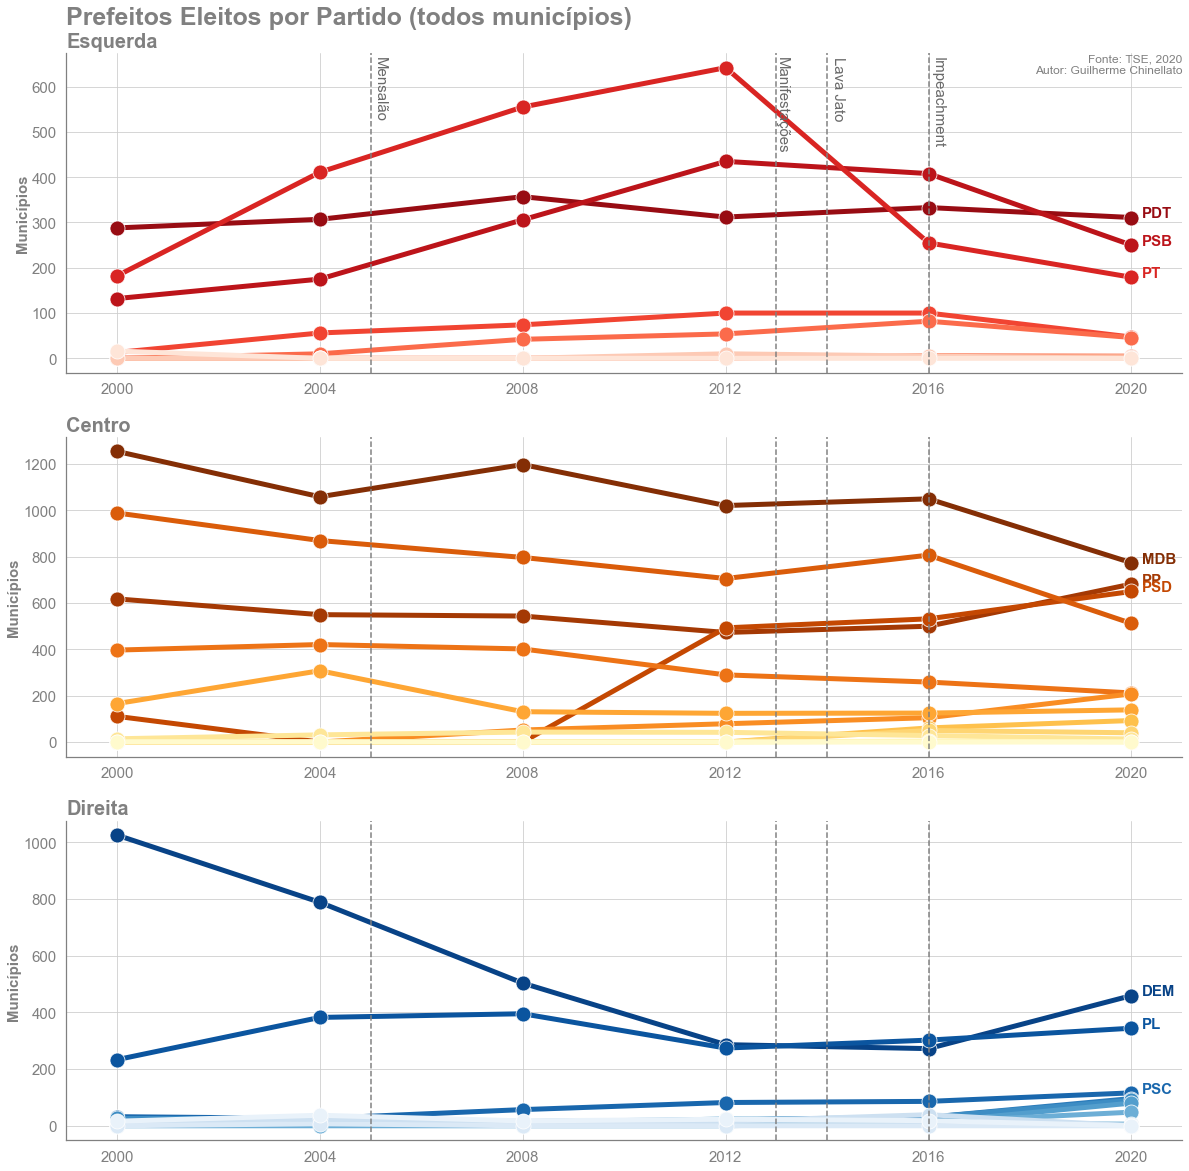

In [440]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title = 'Prefeitos Eleitos por Partido (todos municípios)'
legend = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

draw_subplots(axs, r_esq, r_centro, r_dir) 

plt.savefig('output/prefeitos_partido_total.png', dpi=300, bbox_inches = 'tight')

Resultado agregado

In [441]:
agg_total = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq.index):
    agg_total.loc[v,'Esquerda'] = r_esq.loc[v].sum()

for k,v in enumerate(r_centro.index):
    agg_total.loc[v,'Centro'] = r_centro.loc[v].sum()
    
for k,v in enumerate(r_dir.index):
    agg_total.loc[v,'Direita'] = r_dir.loc[v].sum()

In [442]:
agg_total

,Esquerda,Centro,Direita
2000,631,3551,1361
2004,959,3240,1360
2008,1334,3167,1056
2012,1555,3228,785
2016,1191,3521,835
2020,842,3324,1241


In [443]:
agg_total_var = agg_total.pct_change().stack().reset_index()
agg_total_var.columns = ['Ano','Ideologia', 'Variação']
agg_total.pct_change()

,Esquerda,Centro,Direita
2000,NaN,NaN,NaN
2004,0.519810,-0.087581,-0.000735
2008,0.391032,-0.022531,-0.223529
2012,0.165667,0.019261,-0.256629
2016,-0.234084,0.090768,0.063694
2020,-0.293031,-0.055950,0.486228


### Municípios >200mil habitantes

In [444]:
r_esq_200mil = res_200mil[res_200mil.ideologia == 'Esquerda']
r_esq_200mil = r_esq_200mil.drop('ideologia', axis=1).T
r_esq_200mil = r_esq_200mil.fillna(0).astype(int)
r_esq_200mil.sort_values(r_esq_200mil.index[-1], axis=1, ascending=False, inplace=True)

r_centro_200mil = res_200mil[res_200mil.ideologia == 'Centro']
r_centro_200mil = r_centro_200mil.drop('ideologia', axis=1).T
r_centro_200mil = r_centro_200mil.fillna(0).astype(int)
r_centro_200mil.sort_values(r_centro_200mil.index[-1], axis=1, ascending=False, inplace=True)

r_dir_200mil = res_200mil[res_200mil.ideologia == 'Direita']
r_dir_200mil = r_dir_200mil.drop('ideologia', axis=1).T
r_dir_200mil = r_dir_200mil.fillna(0).astype(int)
r_dir_200mil.sort_values(r_dir_200mil.index[-1], axis=1, ascending=False, inplace=True)

In [445]:
agg_200mil = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_200mil.index):
    agg_200mil.loc[v,'Esquerda'] = r_esq_200mil.loc[v].sum()

for k,v in enumerate(r_centro_200mil.index):
    agg_200mil.loc[v,'Centro'] = r_centro_200mil.loc[v].sum()
    
for k,v in enumerate(r_dir_200mil.index):
    agg_200mil.loc[v,'Direita'] = r_dir_200mil.loc[v].sum()

In [446]:
agg_200mil

,Esquerda,Centro,Direita
2000,47,65,21
2004,58,71,15
2008,64,67,17
2012,60,77,12
2016,31,96,22
2020,10,59,17


In [447]:
agg_200mil_var = agg_200mil.pct_change().stack().reset_index()
agg_200mil_var.columns = ['Ano','Ideologia', 'Variação']
agg_200mil.pct_change()

,Esquerda,Centro,Direita
2000,NaN,NaN,NaN
2004,0.234043,0.092308,-0.285714
2008,0.103448,-0.056338,0.133333
2012,-0.062500,0.149254,-0.294118
2016,-0.483333,0.246753,0.833333
2020,-0.677419,-0.385417,-0.227273


### Capitais

In [448]:
r_esq_capitais = res_capitais[res_capitais.ideologia == 'Esquerda']
r_esq_capitais = r_esq_capitais.drop('ideologia', axis=1).T
r_esq_capitais = r_esq_capitais.fillna(0).astype(int)
r_esq_capitais.sort_values(r_esq_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_centro_capitais = res_capitais[res_capitais.ideologia == 'Centro']
r_centro_capitais = r_centro_capitais.drop('ideologia', axis=1).T
r_centro_capitais = r_centro_capitais.fillna(0).astype(int)
r_centro_capitais.sort_values(r_centro_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_dir_capitais = res_capitais[res_capitais.ideologia == 'Direita']
r_dir_capitais = r_dir_capitais.drop('ideologia', axis=1).T
r_dir_capitais = r_dir_capitais.fillna(0).astype(int)
r_dir_capitais.sort_values(r_dir_capitais.index[-1], axis=1, ascending=False, inplace=True)

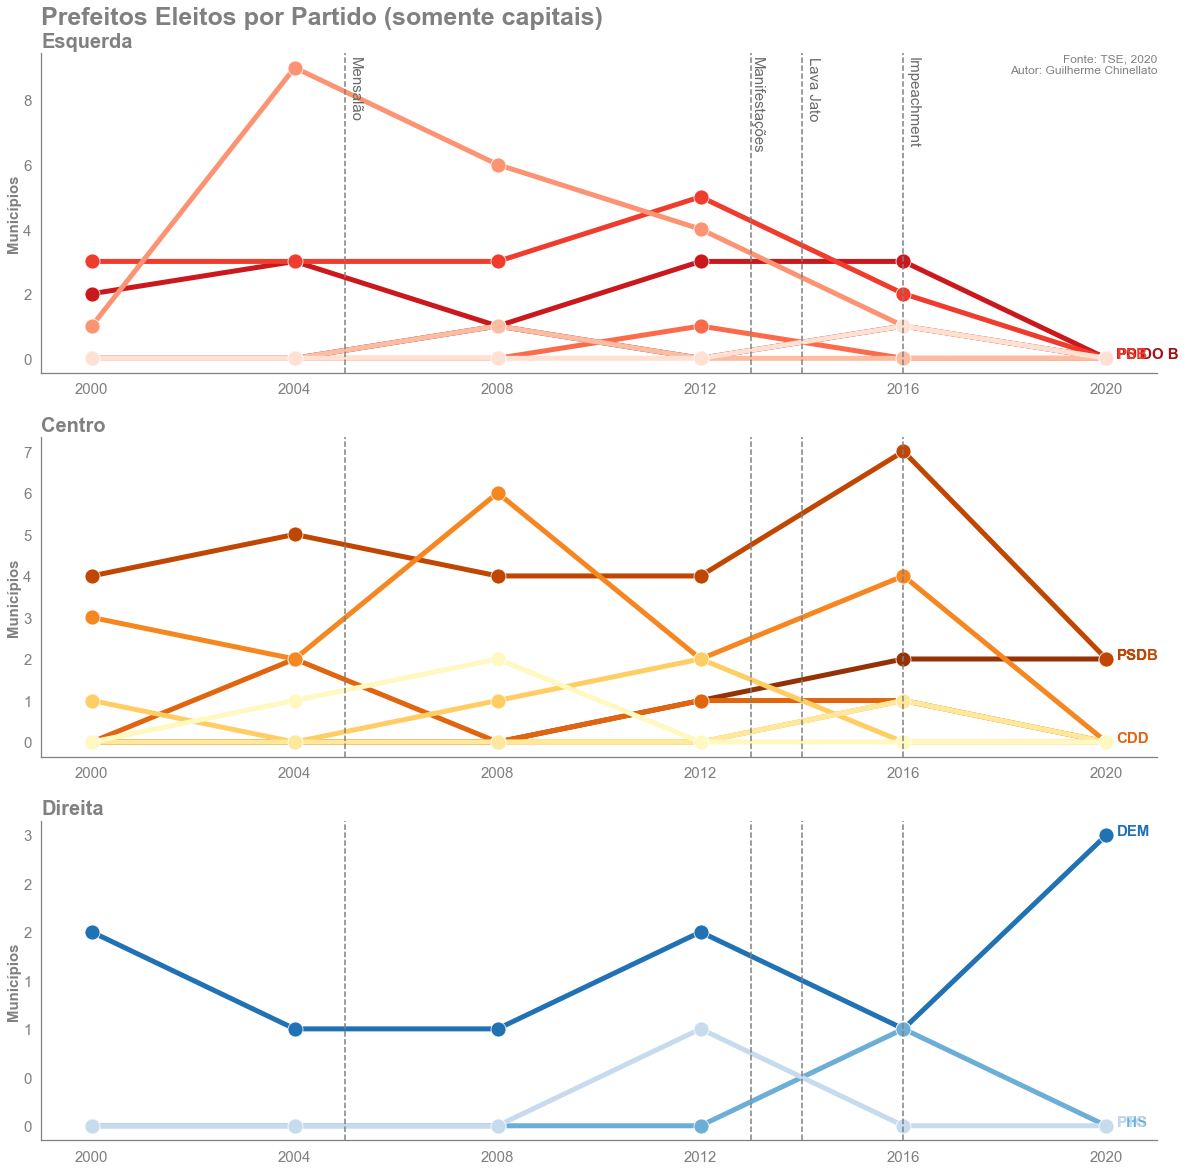

In [449]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title = 'Prefeitos Eleitos por Partido (somente capitais)'
plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

draw_subplots(axs, r_esq_capitais, r_centro_capitais, r_dir_capitais)

plt.savefig('output/prefeitos_partido_capitais.png', dpi=300, bbox_inches = 'tight')

Resultado agregado

In [450]:
agg_capitais = pd.DataFrame(columns=['Esquerda','Centro','Direita'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_capitais.index):
    agg_capitais.loc[v,'Esquerda'] = r_esq_capitais.loc[v].sum()
    
for k,v in enumerate(r_centro_capitais.index):
    agg_capitais.loc[v,'Centro'] = r_centro_capitais.loc[v].sum()
    
for k,v in enumerate(r_dir_capitais.index):
    agg_capitais.loc[v,'Direita'] = r_dir_capitais.loc[v].sum()

In [451]:
agg_capitais

,Esquerda,Centro,Direita
2000,6,8,2
2004,15,10,1
2008,12,13,1
2012,13,10,3
2016,8,16,2
2020,0,4,3


In [452]:
agg_capitais_var = agg_capitais.pct_change().stack().reset_index()
agg_capitais_var.columns = ['Ano','Ideologia', 'Variação']
agg_capitais.pct_change()

,Esquerda,Centro,Direita
2000,NaN,NaN,NaN
2004,1.500000,0.250000,-0.500000
2008,-0.200000,0.300000,0.000000
2012,0.083333,-0.230769,2.000000
2016,-0.384615,0.600000,-0.333333
2020,-1.000000,-0.750000,0.500000


# Evolução de prefeitos eleitos por densidade populacional do município

In [453]:
df[df.ano_eleicao == 2016].drop_duplicates(subset='codigo_municipio', keep='first')['densidade'].describe([.05,.25, .5, .75,.95])

count     5547.000000
mean       120.881420
std        633.135394
min          0.040321
5%           2.468260
25%         11.678201
50%         25.079763
75%         56.295418
95%        285.851936
max      14403.178340
Name: densidade, dtype: float64

In [454]:
res_den = pd.DataFrame()
for i, val in enumerate(ano_da_eleicao):
    df_temp = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')
    df_temp = df_temp.groupby(['grupo_densidade','ideologia'])['ideologia'].count().unstack()
    df_temp.fillna(0, inplace=True)
    df_temp['year'] = val
    res_den = res_den.append(df_temp) 
    
res_den.reset_index(drop=False, inplace=True)
res_den = res_den[['year','grupo_densidade','Esquerda','Centro','Direita']]

Preparar dataset para flourish

In [455]:
res_den.to_excel('output/flourish_municipios_densidade.xlsx')

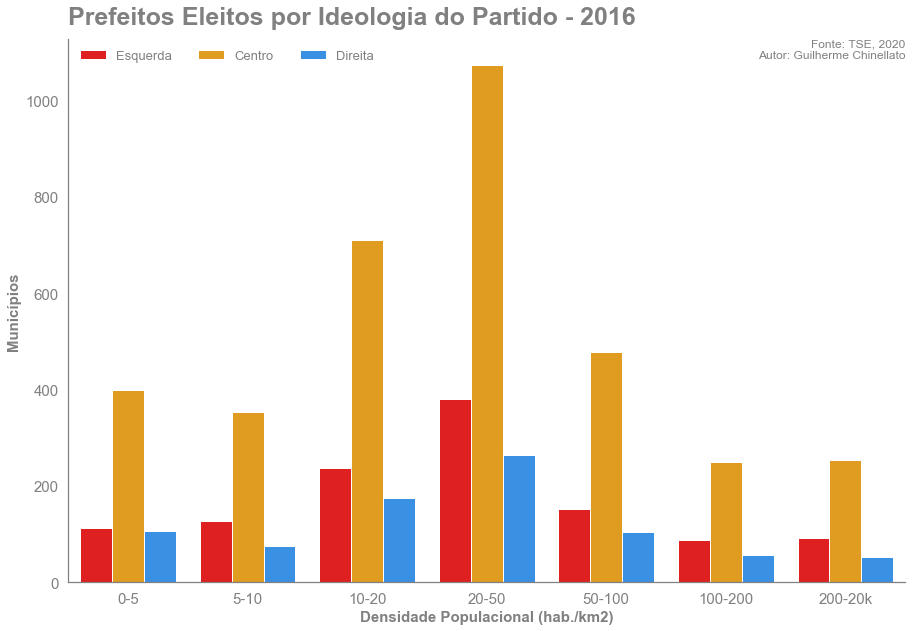

In [456]:
colors = ['red', 'orange', 'dodgerblue']

year = 2016
fig, ax = plt.subplots(figsize = (15,10))

sns.set_style('white')
sns.despine()

title='Prefeitos Eleitos por Ideologia do Partido - ' + str(year)
plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

d = sns.catplot(data=res_den[res_den.year == year].iloc[:,1:].set_index('grupo_densidade').stack().reset_index(),
                x='grupo_densidade', y=0, hue='ideologia', kind='bar', palette=colors, ax=ax)


ax.set_xlabel('Densidade Populacional (hab./km2)', fontsize=15, fontweight='bold', color='grey')
ax.set_ylabel('Municípios', fontsize=15, fontweight='bold', color='grey')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')

ax.set_yscale('linear')
ax.set_xticklabels(density_label, fontsize=15, color='grey')
ax.set_yticklabels(labels=[int(i) for i in ax.get_yticks()], fontsize=15, color='grey')

ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

l = ax.legend(loc='upper left', ncol=4, fontsize=13)
for text in l.get_texts():
    text.set_color('grey')

ax.text(1.0, 1.0, legend, transform=ax.transAxes, fontsize=12, ha='right', va='top', color='grey')

plt.close(2)
plt.savefig('output/prefeitos_ideologia_densidade_'+str(year)+'.png', dpi=300, bbox_inches = 'tight')

Analisando a evolução nos municípios com maior e menor densidade populacional

In [457]:
res_den_maior = res_den[res_den.grupo_densidade == 6].copy()
res_den_maior.drop('grupo_densidade',axis=1,inplace=True)
res_den_maior.set_index('year', inplace=True)

In [484]:
res_den_maior

ideologia,Esquerda,Centro,Direita
year,,,
2000,100,217,71
2004,105,222,72
2008,136,209,54
2012,158,205,37
2016,93,254,52
2020,44,216,86


In [458]:
res_den_menor = res_den[res_den.grupo_densidade != 6].groupby('year').sum()
res_den_menor.drop('grupo_densidade',axis=1,inplace=True)

In [494]:
res_den_menor

ideologia,Esquerda,Centro,Direita
year,,,
2000,531,3334,1290
2004,854,3018,1288
2008,1198,2958,1002
2012,1397,3023,748
2016,1098,3267,783
2020,798,3108,1155


In [493]:
print('Maiores Municípios - '+str(2020))
print('Esquerda: '+str(round(res_den_maior.loc[2020,'Esquerda'] / res_den_maior.loc[2020].sum()*100,2))+'%')
print('Centro: '+str(round(res_den_maior.loc[2020,'Centro'] / res_den_maior.loc[2020].sum()*100,2))+'%')
print('Direita: '+str(round(res_den_maior.loc[2020,'Direita'] / res_den_maior.loc[2020].sum()*100,2))+'%')

Maiores Municípios - 2020
Esquerda: 12.72%
Centro: 62.43%
Direita: 24.86%


In [495]:
print('Menores Municípios - '+str(2020))
print('Esquerda: '+str(round(res_den_menor.loc[2020,'Esquerda'] / res_den_menor.loc[2020].sum()*100,2))+'%')
print('Centro: '+str(round(res_den_menor.loc[2020,'Centro'] / res_den_menor.loc[2020].sum()*100,2))+'%')
print('Direita: '+str(round(res_den_menor.loc[2020,'Direita'] / res_den_menor.loc[2020].sum()*100,2))+'%')

Menores Municípios - 2020
Esquerda: 15.77%
Centro: 61.41%
Direita: 22.82%


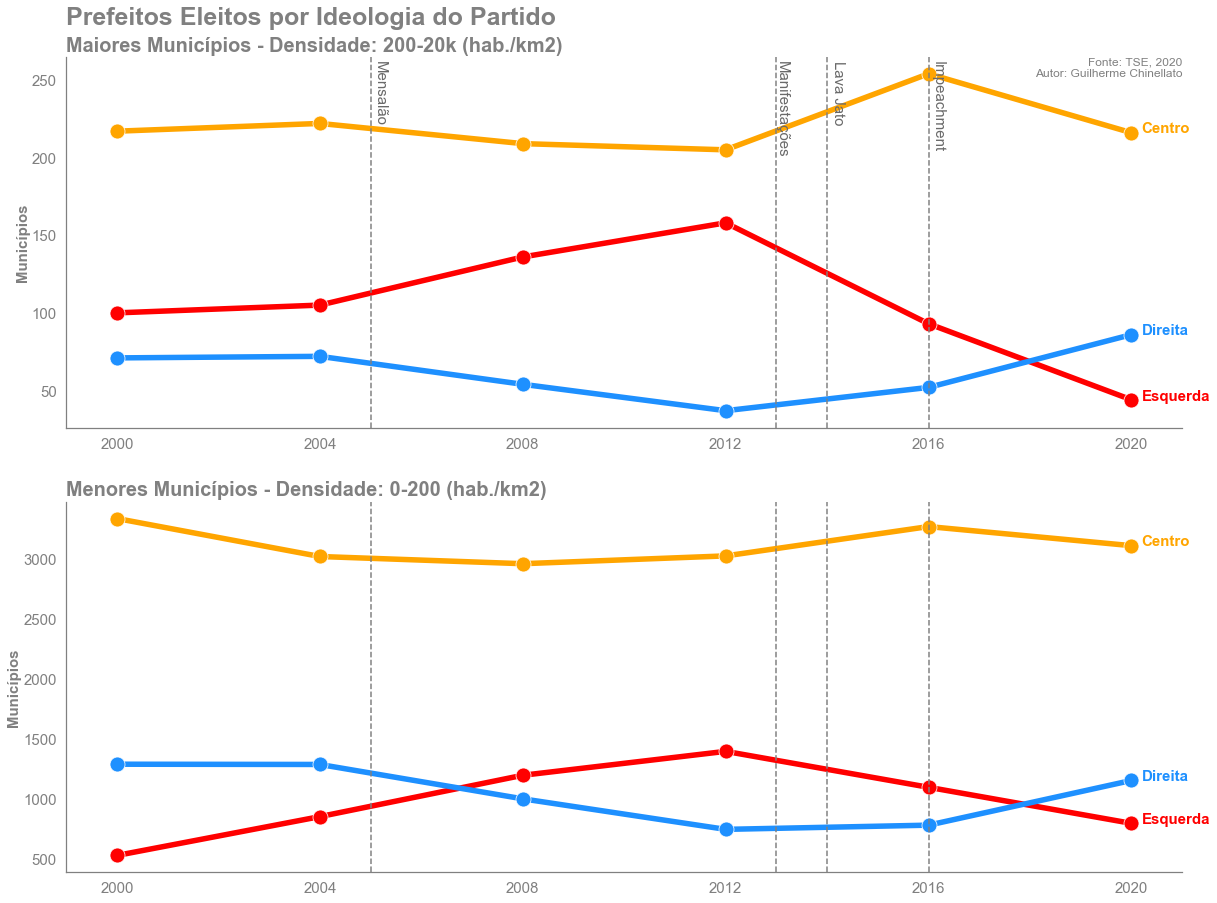

In [459]:
fig, axs = plt.subplots(2,1, figsize = (20,15))

sns.set_style('white')
sns.despine()

title='Prefeitos Eleitos por Ideologia do Partido'
plt.text(x=0.125, y=0.91, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

l_maior = sns.lineplot(data=res_den_maior, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[0])
l_menor = sns.lineplot(data=res_den_menor, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[1])

axs[0].set_title('Maiores Municípios - Densidade: 200-20k (hab./km2)', loc='left',
                 fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Menores Municípios - Densidade: 0-200 (hab./km2)', loc='left',
                 fontsize=20, fontweight='bold', color='grey')

axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))

axs[0].set_xlabel('')
axs[1].set_xlabel('')

axs[0].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')

axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey') 

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

handles, labels = axs[0].get_legend_handles_labels()
leg = l_maior.legend(flip(handles, 4), flip(labels, 4), loc=2, ncol=4, fontsize=15, borderaxespad=0.)    
for line in leg.get_lines():
    line.set_linewidth(5.5)
    
axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

for i in range(len(axs[0].get_lines())):
    axs[0].text(res_den_maior.index[-1]+.2, res_den_maior.iloc[-1,i], res_den_maior.columns[i],
                fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

for i in range(len(axs[0].get_lines())):
    axs[1].text(res_den_menor.index[-1]+.2, res_den_menor.iloc[-1,i], res_den_menor.columns[i],
                fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

axs[0].axvline(2005, color='grey', linestyle='--')
axs[0].axvline(2013, color='grey', linestyle='--')
axs[0].axvline(2014, color='grey', linestyle='--')
axs[0].axvline(2016, color='grey', linestyle='--')

axs[1].axvline(2005, color='grey', linestyle='--')
axs[1].axvline(2013, color='grey', linestyle='--')
axs[1].axvline(2014, color='grey', linestyle='--')
axs[1].axvline(2016, color='grey', linestyle='--')

axs[0].text(0.275, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.635, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.685, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.775, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')

plt.savefig('output/prefeitos_densidade_maiores_menores.png', dpi=300, bbox_inches = 'tight')

Variação entre eleições

In [460]:
res_den_maior_var = res_den_maior.pct_change().stack().reset_index()
res_den_maior_var.columns = ['Ano','Ideologia','Variação']

res_den_menor_var = res_den_menor.pct_change().stack().reset_index()
res_den_menor_var.columns = ['Ano','Ideologia','Variação']

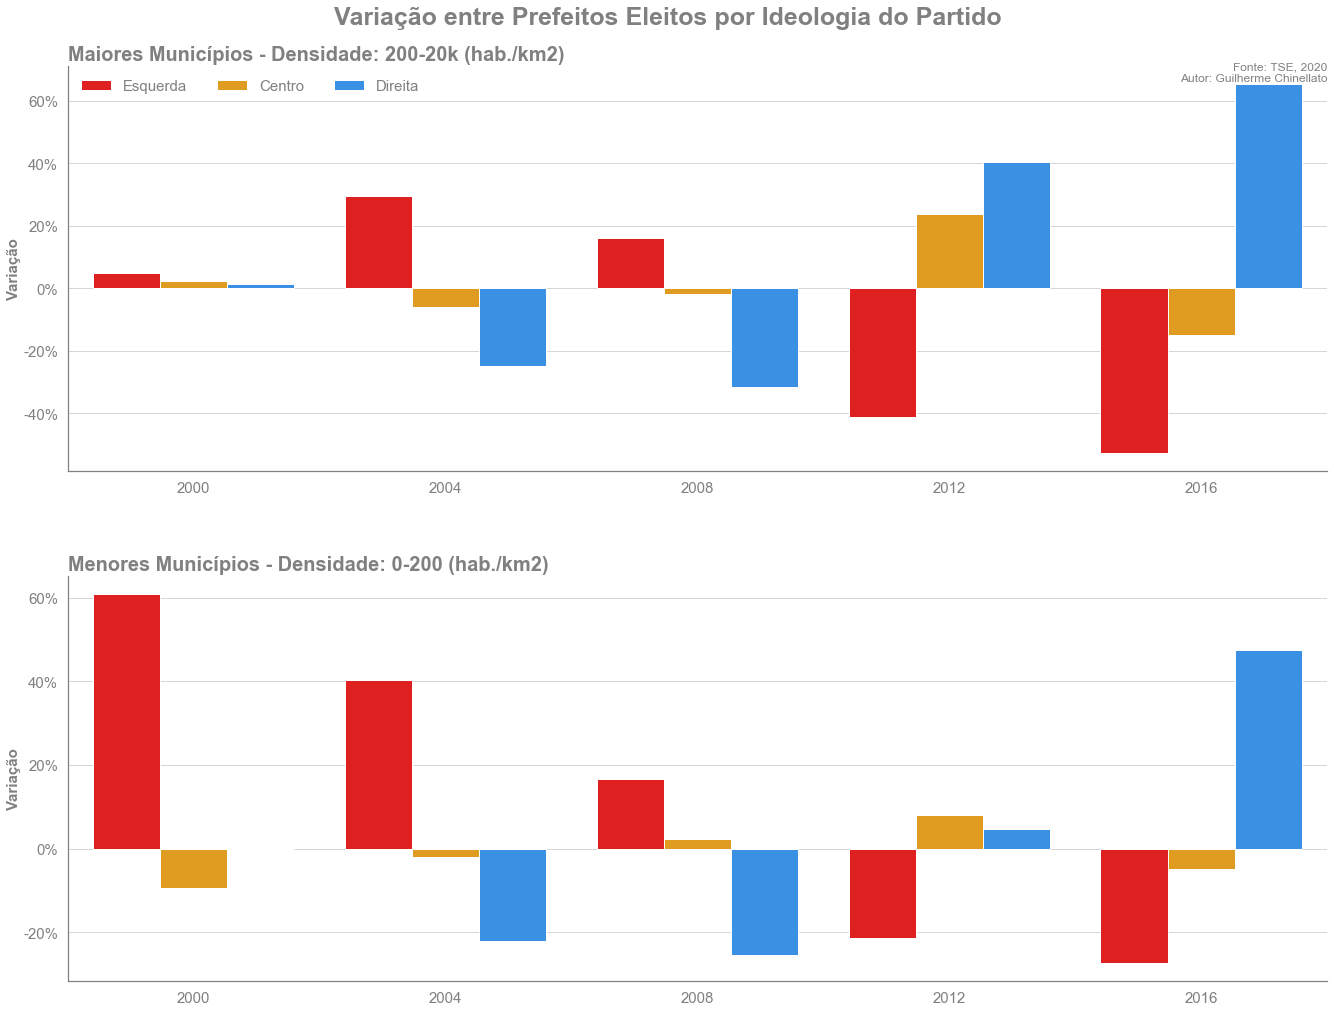

In [474]:
fig, axs = plt.subplots(2,1, figsize = (20,15))

sns.set_style('whitegrid')
sns.despine()

c_maior = sns.catplot(data=res_den_maior_var, x='Ano', y='Variação', hue='Ideologia', kind='bar',
                      palette=colors, ax=axs[0])
c_menor = sns.catplot(data=res_den_menor_var, x='Ano', y='Variação', hue='Ideologia', kind='bar'
                      , palette=colors, ax=axs[1])

title='Variação entre Prefeitos Eleitos por Ideologia do Partido'
plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

fig.suptitle('Variação entre Prefeitos Eleitos por Ideologia do Partido', fontsize=25, fontweight='bold',
             color='grey')

axs[0].set_title('Maiores Municípios - Densidade: 200-20k (hab./km2)', loc='left', fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Menores Municípios - Densidade: 0-200 (hab./km2)', loc='left', fontsize=20, fontweight='bold', color='grey')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

axs[0].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticklabels(labels=[ano_da_eleicao[i] for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[ano_da_eleicao[i] for i in axs[1].get_xticks()], fontsize=15, color='grey')

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey') 

l = axs[0].legend(loc='upper left', ncol=4, fontsize=15)
for text in l.get_texts():
    text.set_color('grey')
axs[1].get_legend().remove()

axs[0].text(1.0, 1.01, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

plt.close(2)
plt.close(3)
fig.tight_layout(pad=6)
plt.savefig('output/prefeitos_densidade_maiores_menores_var.png', dpi=300, bbox_inches = 'tight')

Correlação entre:
- Maiores Municípios vs Menores Municípios
- Maiores Municípios vs Capitais
- Menores Municípios vs Capitais

In [462]:
corr = pd.DataFrame()
corr['Maiores/Menores'] = res_den_maior.corrwith(res_den_menor, axis=0)
corr['Maiores/Capitais'] = res_den_maior.corrwith(agg_capitais, axis=0)
corr['Menores/Capitais'] = res_den_menor.corrwith(agg_capitais, axis=0)

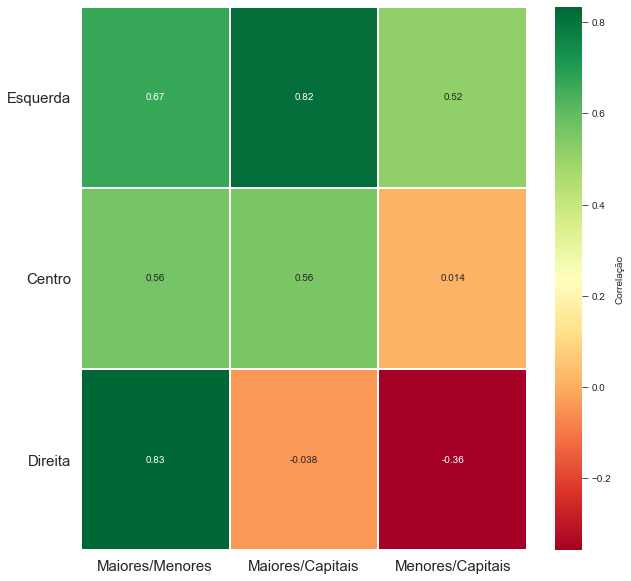

In [463]:
fig, ax = plt.subplots( figsize = (10,10))

hm = sns.heatmap(corr, cmap='RdYlGn', ax=ax, linewidths=1,
                 cbar_kws={'label': 'Correlação', 'orientation': 'vertical'},
                 annot=True, xticklabels=True, yticklabels=True)

ax.set_ylabel('')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize=15)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize=15)
plt.savefig('output/correl.png', dpi=300, bbox_inches = 'tight')

In [464]:
df_merge = pd.merge(res_den_maior.stack().reset_index(), res_den_menor.stack().reset_index(), how='left', on=['year', 'ideologia'])
temp = agg_capitais.stack().reset_index()
temp.columns = ['year','ideologia','capitais']
df_merge = pd.merge(df_merge, temp, how='left', on=['year', 'ideologia'])
df_merge.columns = ['Ano','Ideologia','Maiores Municípios','Menores Municípios','Capitais']

Pairplot

C:\Users\guilh\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


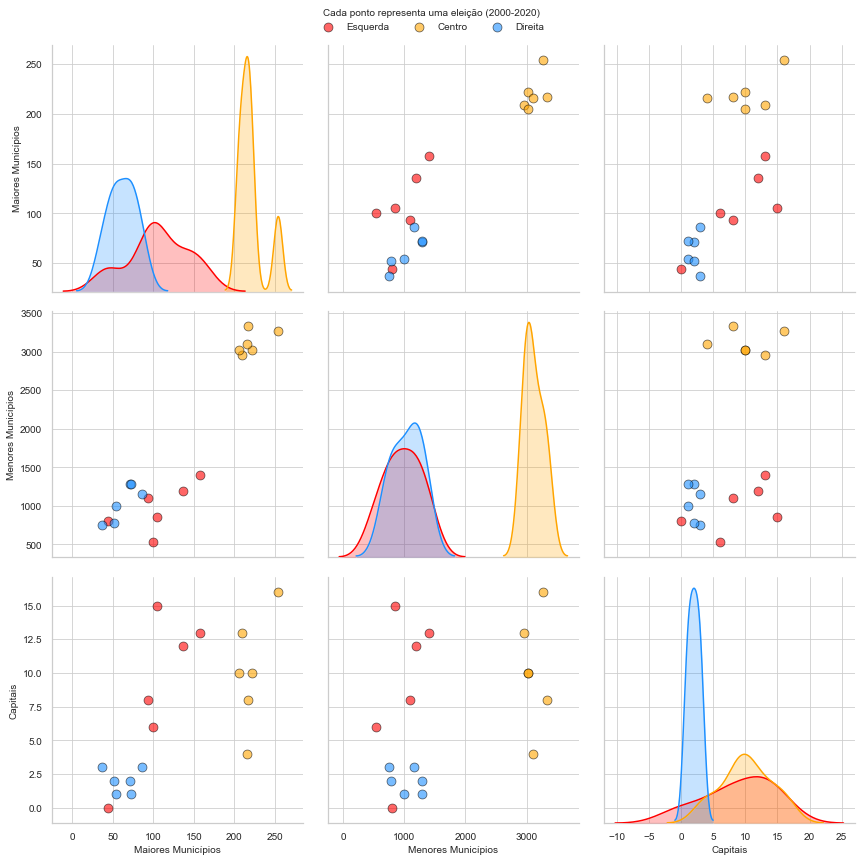

In [465]:
pp = sns.pairplot(df_merge.drop('Ano',axis=1), hue='Ideologia', kind='scatter', size=4, palette=colors,
                  plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

#plt.suptitle('Prefeito Eleitos por Tamanho do Município', size=20, fontweight='bold', y=1.05)

pp._legend.remove()
handles = pp._legend_data.values()
labels = pp._legend_data.keys()
pp.fig.legend(handles=handles, labels=labels, title='Cada ponto representa uma eleição (2000-2020)',
              loc='upper center', ncol=4)
pp.fig.subplots_adjust(top=0.95)

#plt.tight_layout(pad=10.0)
plt.savefig('output/pairplot.png', dpi=300, bbox_inches = 'tight')

# Mapa Brasil

Preparar dataset para flourish

In [466]:
df_temp = df[df.ano_eleicao == 2016].drop_duplicates(subset='codigo_municipio', keep='first')
df_temp.drop(['ano_eleicao','codigo_municipio','sigla_uf','nome_partido','numero_partido',
             'sigla_partido','nome','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)
df_temp = df_temp[['nome_municipio','ideologia','latitude','longitude','População','densidade']]

In [467]:
df_temp.to_excel('output/flourish_mapa_populacao.xlsx')

Mapa do Brasil com quantidade de votos em prefeitos com determinada ideologia do partido

In [475]:
df_novo = df.copy()
df_novo = df_novo[df_novo.ano_eleicao == 2016].drop_duplicates(subset='codigo_municipio', keep='first')
df_novo['CD_GEOCMU'] = df_novo['GEOCOD_IBGE'].astype(str)

df_novo.drop(['ano_eleicao','codigo_municipio','nome_partido','numero_partido',
             'sigla_partido','nome','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)

In [476]:
df_mapa = gpd.read_file('input/geo/br_municipios/BRMUE250GC_SIR.shp')
df_mapa['NM_MUNICIP'] = df_mapa['NM_MUNICIP'].str.upper().apply(lambda x: unidecode(x))

df_mapa_novo = pd.merge(df_mapa, df_novo, how='left', on='CD_GEOCMU')
df_mapa_novo.set_index('CD_GEOCMU', inplace=True)
df_mapa_novo.dropna(inplace=True)

In [477]:
df_mapa_uf = gpd.read_file('input/geo/br_unidades_da_federacao/BR_UF_2019.shp')

df_novo_uf = df_novo.groupby(['sigla_uf','ideologia'])['CD_GEOCMU'].count().unstack().reset_index()
df_novo_uf['max'] = df_novo_uf[['Centro','Direita','Esquerda']].idxmax(axis=1)

df_mapa_uf_novo = df_mapa_uf.join(df_novo_uf)
df_mapa_uf_novo.dropna(inplace=True)

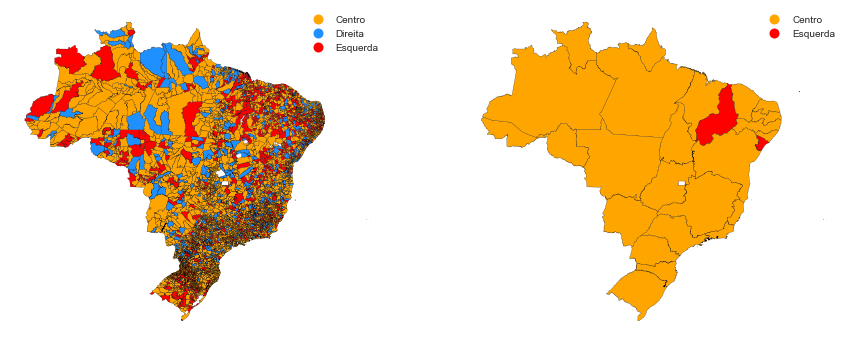

In [478]:
fig, axs = plt.subplots(1,2,figsize=(15,15))
#fig.suptitle('Ideologia com mais Prefeitos Eleitos - '+str(year), fontsize=25, fontweight='bold')

p1 = df_mapa_novo.plot(column='ideologia', cmap=ListedColormap(['orange','dodgerblue','red']), legend=True, linewidth=0.2, ax=axs[0], edgecolor='black')
p2 = df_mapa_uf_novo.plot(column='max', cmap=ListedColormap(['orange','red']), legend=True, linewidth=0.2, ax=axs[1], edgecolor='black')

p1.set_axis_off()
p2.set_axis_off()

#p1.annotate('Fonte: TSE, 2020; IBGE, 2015; Autor: Guilherme Chinellato', xy=(0.1,0.08),
#            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

#plt.tight_layout(pad=5)
fig.savefig('output/brasil_municipios_'+str(year)+'.png', dpi=300, bbox_inches = 'tight')

# Conclusão

Observando o gráfico de tendência dividido por ideologia dos partidos é possível notar que não existe uma grande diferença no comportamento de voto por determinada ideologia entre grandes e pequenos municípios.

Por exemplo, os partidos de **esquerda** estão em baixa desde 2012, tanto entre cidades com grande densidade populacional e cidades menores. Da mesma forma que o **centro** se manteve estável ao longo do tempo em ambos cenários, mas em 2020 perderam espaço para partidos de **direita**.

O gráfico de variação deixa evidente que o eleitorado é sazonal. Entre as eleições de 2004, 2008 e 2012 o mesmo movimento é similar nos dois cenários, porém na eleição de 2016, a **direita** conquista um grande espaço nas grandes cidades e não tanto nas cidades menores. As grandes cidades respondem de forma muita rápida manifestações nacionais, independente da ideologia, movimento que só acontece nos municípios menores na próxima eleição, como em 2020.

A hipótese de que <ins>grandes centros são mais *progressistas* no Brasil não se confirma</ins>, pois a relação entre municípios com grande e pouca densidade populacional é a mesma ao longo do tempo. O **centro** sempre como grupo político mais forte, seguido por **esquerda** e **direita** até 2016, porém em 2020, a **direita** se torna a segunda maior ideologia com prefeitos eleitos entre cidade grandes e menores.

Atualmente, nas grandes cidades, o **centro** representa 62%, **direita** 25% e **esquerda** 13%.
O partido com mais prefeitos eleitos da **esquerda** é o PDT, onde o PT continua em plena queda desde 2012. Entre o **centro** os principais partidos são MDB, PP e PSD e na **direita** o DEM está em ascensão.

Um fator interessante de analisar é a correlação entre cidades maiores, menores e somente capitais.
A **esquerda** possui correlação positiva nas três comparações, indicando que uma ascensão ou declínio tende a refletir em conjunto em capitais, cidades grandes e pequenas.

Porém, a **direita** não apresenta o mesmo comportamento de correlação quando capitais são envolvidas.